Tukaj je povzetek stvari ki sem jih poskusil. Najprej sem si pripravil podatke, tako da sem iz originalnih časovnih vrst pobrisal vrstice, ki opisujejo le recimo province ali kaj podobnega. Drugače je problem da se algoritem preveč prilagaja podatkom iz kitajske. Hkrati sem še iz ene knjižnjice pobral populacije držav, da lahko računam odstotek potrjeno okuženih ljudi. 

Nato sem si pobral časovne vrste, kjer ena časovna vrsta vsebuje 23 dni podatkov-16 dni za nazaj in 7 dni vnaprej. Modeli lahko nato dostopajo le do podatkov za nazaj, predvideti pa morajo število potrjenih okužb čez 7 dni. Hkrati pa dobijo na voljo še prebivalstvo neke države. Kot napako za ocenjevanje različnih modelov sem vzel povprečje kvadratov odstopanj deljeno z 10^6 da so številke bolj predstavljive. Koren napake bi nam potem lahko morda povedal za koliko 1000 bomo povprečno zgrešili. 

Nato sem kot nek "baseline" uporabil algoritem ki enostavno reče, da bo število okužb čez 7 dni enako kot število okužb včeraj. To mi je dalo povprečno napako nekje 560. 

Naslednja ideja je, da število okužb narašča linerano. Potem izračunamo razliko med včeraj in danes, ter jo pomnožimo s 7 da dobimo število okužb čez 7 dni. To da zelo majhno napako okoli 40. 

Potem poskusimo oceniti da se epidemije v resnici širijo eksponentno. Torej da je razmerje med včeraj in danes, enako razmerju med danes in jutri. To se izkaže kot zelo slab model, ker države načeloma uvajajo ukrepe, ki to razmerje zmanjšujejo, pa še če model naredi napako, jo bo eksponenta funkcija zelo povečala. Napaka je okoli 480. 

Nato sem poskusil napako minimizirati tako, da sem ocenil da bo število okužb čez 7 dni neka linearna kombinacija števila okužb iz preteklosti. Da minimiziram overfit, sem vzel nekje 6-7 dni in optimiziral to linearno kominacijo z neke vrste "hill climbingom". To mi je napako iz 40 spravilo na 39, kar ni neka super izboljšava...

Naslednja ideja je, da če je okužen večji del populacije, potem število novih okužb verjetno malo pade, prvič zaradi imunosti(verjetno manjši del) predvsem pa zaradi bolj intenzivnih ukrepov držav. Da to dodamo v naš model sem ocene modela pomnožil z 1/(a+b*(delež potrjenih okužb)) kar bo pri pozitivnem b in večjem odstotku okužb rahlo znižalo oceno. Ta optimizacija mi v kombinaciji s prejšnim algoritmom napako zniža iz 39 na 36.3.

Potem sem poskusil z malo drugačnim pristopom. Namesto da ocenjujem število potrjenih okužb čez 1 teden, sem šel oceniti število novih okužb od danes do + 1 teden. To število sem spet ocenil z linearno kombinacijo števila novih okužb (torej razlik okužb med sosednjimi dnevi) in z "hill climbing" optimizacijo prišel do precej boljše napake 28.5

Nato sem še na ta model dodal isti popravek kot prej, torej večji odstotek kot je okužen, manj bo novih okužb. To sicer sedaj napake ni bistveno zmanjšalo, prišel sem do napake 28.3 in z enim popravkom 27.8. Rekel bi sicer da je to morda celo slabši rezultat, kot prejšnjih 28.5 ker je možno da je tukaj model "overfittal" bolj kot prej, ker je imel na voljo 2 dodatni spremenljivki, rezultat pa se je precej malo izboljšal. So pa razlike med modeloma precej majhne, tako da mislim da je vseeno kateri se potem uporabi. 

Še malo statistične analize. Model z napako 27.8 kar je kvadrat napake malo analiziram. Če izračunam povprečno napako za vse časovne vrste ki sem jih pobral iz tabele, dobim povprečno napako 1500(model povprečno zgeši število okužb za 1500). Povsem na dnu sem za vsako državo izračunal, koliko je povprečna napaka/število okužb v odstotkih po celotni časovni vrsti, iz kjer sem dobil podatke. Povprečno zgrešim za nekje 5%, v veliki večini pa zgrešim za manj kot 10%. 

In [1]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams["figure.figsize" ] = [20, 16]
input_length=16#koliko dni do danes dobimo podatke?
output_distance=7#za koliko dni vnaprej moramo napovedati stanje?
sample_length=input_length+output_distance

Poberemo podatke o številu okužb po dnevih

In [2]:
path="./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df=pd.read_csv(path)
width=len(df.columns)-4 #Širina časovnega zaporedja
height=len(df)
df.head(50)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,584,609,634,663,678,712,726,736,750,766
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,717,717,723,723,731,738,738,743,743,743
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,24,25,25,25,25,26,27,27,27
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,23,23,24,24,24,24,24,24,24,24
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,2941,3031,3144,3435,3607,3780,3892,4003,4127,4285
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,1339,1401,1473,1523,1596,1677,1746,1808,1867,1932
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,104,104,104,104,105,106,106,106,106,106
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,2963,2969,2971,2976,2982,2994,3002,3004,3016,3016


Iz teh podatkov naredimo seznam časovnih vrst. 

In [3]:
import geonamescache
from geonamescache.mappers import country

gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
mapper = country(from_key='name', to_key='iso')
#print(countries)
series=[]
names=[]
population=[]
for row in range(height):
    data=[]
    if len(str(df["Province/State"][row]))>3:
        #print(df["Province/State"][row])
        continue
    for col in range(4,len(df.columns)):
        data.append(df[df.columns[col]][row]) 
    if(mapper(df["Country/Region"][row])!=None):
        series.append(data)
        names.append(df["Country/Region"][row])
        #print(str(names[-1])+" "+str(mapper(names[-1])))
        population.append(countries[mapper(names[-1])]["population"])
    else:
       #print(df["Country/Region"][row])
        pass
#for i in range(len(names)):
    #print(str(names[i])+" "+str(population[i]))
#print(str(series).replace("[","{").replace("]","}"))

Vzamemo neko funkcijo za napako ki je odporna na b=0, ampak vseeno rajši aproksimira relativno napako, ker nas ta precej bolj zanima

In [4]:
def err(x,a):
    return (x-a)**2

Napišemo si funkcijo ki oceni nek (model?) algoritem.

In [152]:
class Data_segment:
    def __init__(self,input_list,name,population,row):
        assert len(input_list)==sample_length
        self.input=input_list[0:input_length]
        self.output=input_list[-1]
        self.raw=input_list[:]
        self.name=name
        self.population=population
        self.row=row

In [154]:
def input_generator():
    inputs=[]
    for row in range(len(series)):
        for c in range(len(series[row])-sample_length):
            if series[row][c]>50:#Vsaj 50 okužb da začnemo analizirati podatke
                list=series[row][c:c+sample_length]
                inputs.append(Data_segment(list,names[row],population[row],row))
                #print(row)
    return inputs

In [7]:
def evaluate(prediction):
    err_sum=0#vsota relativnih napak
    tries=len(inputs)
    for input in inputs:
        response=prediction(input.input,input.population)
        correct=input.output
        error=err(response,correct)
        #print(str(input.input)+" "+str(response)+" "+str(input.ans)+" "+str(error))
        err_sum+=error
    return (err_sum/tries)/(10**6)

In [155]:
inputs=input_generator()
print(len(inputs))
print(inputs[0].raw)
print(inputs[0].input)
print(inputs[0].output)
print(inputs[0].name)
print(inputs[0].population)

2625
[74, 84, 94, 110, 110, 120, 170, 174, 237, 273, 281, 299, 349, 367, 423, 444, 484, 521, 555, 607, 665, 714, 784]
[74, 84, 94, 110, 110, 120, 170, 174, 237, 273, 281, 299, 349, 367, 423, 444]
784
Afghanistan
29121286


Prvi poskus: število okužb jutri bo 0. To bi moralo dati slab rezultat

In [9]:
def return_healthy_for_sure(ls,population):
    return 0
print(evaluate(return_healthy_for_sure))

6159.68167265638


Verjetno je precej boljša ideja da vrnemo število okuženih včeraj. Vsaj spodnja meja se ujema...

In [10]:
def return_yesterday(ls,population):
    return ls[-1]
print(evaluate(return_yesterday))

562.9713315786666


Kot kaže je uporaba malo logike precej boljša. Kdo bi si mislil. Sedaj naredimo interpolacijo iz enega dneva nazaj v "output_distance" dni naprej

In [41]:
def small_interpolation(ls,population):
    return ls[-1]+output_distance*(ls[-1]-ls[-2])
print(evaluate(small_interpolation))

40.238257448


Poskusimo s pomočjo razmerij

In [58]:
def ratio_interpolation(ls,population):
    return ls[-1]*(ls[-1]/ls[-2])**(output_distance)
print(evaluate(ratio_interpolation))

480.7382374941838


Glede na uteži ki smo jih morali dodati da je bil rezultat vsaj približno dober, smo verjetno bistveno divergirali od željenih vrednosti zaradi interpolacije v toliko dni naprej. Poskusimo uporabiti linearno interpolacijo z utežmi

In [59]:
def generate_fit_from_weights_linear(w):
    def linear_weight_interpolation(ls,population):
        weightedTerms=[w[i]*ls[-1-i] for i in range(len(w))]
        return sum(weightedTerms)
    
    return linear_weight_interpolation

def generate_good_linear_interpolation():
    weights=[0 for i in range(input_length)]#Recimo [0,0,0,0] da prvo funkcijo ki vedno vrne 0, [1,0,0,0] pa da funckijo ki gleda včeraj
    weights[0]=1+output_distance
    weights[1]=-output_distance
    best=evaluate(generate_fit_from_weights_linear(weights))
    print(best)
    last=0
    w=0.5#velikost "povprečne" spremembe
    for i in range(25000): 
        if(i%400==0):
            print(i)
        while(True):
            p=random.randrange(len(weights))
            if p in [0,1,2,4,7,10,13]:#Samo za toliko dni nazaj lahko gledamo. Preprečujemo overfit
                break
        change=w*(random.random()-0.5)
        weights[p]+=change
        curr=evaluate(generate_fit_from_weights_linear(weights))
        #print(str(weights)+" "+str(curr))
        if(curr<best):
            best=curr
            if i-last>200:
                last=i
                print(curr)
                print(weights)
        else:
            weights[p]-=change
    print(best)
    print(weights)
    return generate_fit_from_weights_linear(weights)
    
good_linear_interpolation=generate_good_linear_interpolation()

40.238257448
0
40.20517792968326
[8.0, -7.0, 0.0, 0, 0.0, 0, 0, -0.006429471831877975, 0, 0, 0.0, 0, 0, 0.0, 0, 0]
400
40.00857940802578
[7.999999999999999, -6.999141755973043, 0.008067385216584289, 0, 0.0, 0, 0, -0.003491926679744739, 0, 0, -0.015628772946034653, 0, 0, 0.0, 0, 0]
800
39.98227373622062
[7.9999999999999964, -6.999141755973044, 0.009981699976488512, 0, 0.0, 0, 0, -0.003491926679744739, 0, 0, -0.015628772946034653, 0, 0, -0.001009740382759472, 0, 0]
39.86023685143424
[8.007148755964346, -6.999141755973044, 0.009305711320328536, 0, 0.0, 0, 0, -0.003491926679744739, 0, 0, -0.015628772946034653, 0, 0, -0.009577264972424004, 0, 0]
1200
39.7192296815489
[8.007148755964346, -6.997506295358847, 0.012160462445537534, 0, 0.0, 0, 0, -0.0031820953552184617, 0, 0, -0.029343064967328802, 0, 0, -0.009577264972424004, 0, 0]
39.530966099721105
[8.013525555308437, -6.993434153595237, 0.012160462445537534, 0, 0.0, 0, 0, -0.0031820953552184617, 0, 0, -0.03506577393574423, 0, 0, -0.027232424

15600
39.170630874635
[8.026385651564123, -6.981806818923689, 0.016507792841566116, 0, -0.0034332922341270278, 0, 0, -0.03879236836703709, 0, 0, -0.03239762283158604, 0, 0, -0.032863379858896036, 0, 0]
16000
39.166098415538
[8.026385651564123, -6.98007618604544, 0.016507792841566116, 0, -0.0034332922341270278, 0, 0, -0.03879236836703709, 0, 0, -0.03239762283158604, 0, 0, -0.032863379858896036, 0, 0]
16400
39.159435824394095
[8.026385651564123, -6.98007618604544, 0.016507792841566116, 0, -0.004743826183913669, 0, 0, -0.03879236836703709, 0, 0, -0.03239762283158604, 0, 0, -0.03430547806468365, 0, 0]
16800
39.15748087367863
[8.026703261783586, -6.980076186045439, 0.016507792841566116, 0, -0.004743826183913669, 0, 0, -0.03879236836703709, 0, 0, -0.03239762283158604, 0, 0, -0.03430547806468365, 0, 0]
17200
39.1368396879144
[8.026703261783585, -6.980076186045439, 0.01724039865375665, 0, -0.004743826183913669, 0, 0, -0.042573822084531976, 0, 0, -0.03239762283158604, 0, 0, -0.03100028403166194

To nam da nekje 3 krat boljši rezultat. Poskusimo narisati kaj naš algoritem izračuna

In [128]:
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import *
import numpy.ma as ma
while(True):
    pos=random.randrange(len(series))
    row=series[pos]
    if(row[-sample_length-10]>50):
        print(pos)
        print(names[pos])
        break

print(row)
print(population[pos])
shift=0
def update(shift=10):

    x=np.arange(0, len(row), 1);
    y=[]
    lin_p=[]
    #exp_p=[]
    for i in range(len(row)):
        y.append(row[i])

    p=0
    while(p<len(row)):
        if p<sample_length or row[p-sample_length]<50:
            lin_p.append(0)
        else:
            lin_p.append(good_linear_interpolation(y[p-sample_length:p-output_distance],population[pos]))
        p+=1

    #p=0
    #while(p<len(row)):
    #    if p<sample_length or row[p-sample_length]<50:
    #        exp_p.append(0)
    #    else:
    #        exp_p.append(log_weight_interpolation(y[p-sample_length:p-output_distance]))
    #    p+=1

    #errors_lin=[err(lin_p[i],y[i]) for i in range(len(row))]
    #errors_exp=[err(exp_p[i],y[i]) for i in range(len(row))]
    
    
    layerdict = dict()
    layerdict["Xc"] = x
    layerdict["Yc"] = y

    highlightmask = np.ones(len(layerdict['Xc'])).astype(bool)
    highlightmask[-output_distance-shift:] = False

    layerdict['Xc'] = ma.array(layerdict['Xc'])
    layerdict['Yc'] = ma.array(layerdict['Yc'], mask=highlightmask)

    plt.plot(layerdict['Xc'], layerdict['Yc'].data, label='linepath', linewidth=3.5)
    plt.plot(layerdict['Xc'], layerdict['Yc'], 'w', linewidth=3.5)
    
    layerdict2 = dict()
    layerdict2["Xc"] = x
    layerdict2["Yc"] = lin_p

    highlightmask2 = np.ones(len(layerdict2['Xc'])).astype(bool)
    highlightmask2[-shift:-shift+1] = False

    layerdict2['Xc'] = ma.array(layerdict2['Xc'])
    layerdict2['Yc'] = ma.array(layerdict2['Yc'], mask=highlightmask2)
    
    plt.plot(layerdict2['Xc'], layerdict2['Yc'].data, label='linepath', linewidth=.5)
    plt.plot(layerdict2['Xc'], layerdict2['Yc'], 'o', linewidth=3.5)
    plt.show()

interact(update, shift = widgets.IntSlider(value=10, min=0, max=80, step=1))

8
Austria
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 3, 9, 14, 18, 21, 29, 41, 55, 79, 104, 131, 182, 246, 302, 504, 655, 860, 1018, 1332, 1646, 2013, 2388, 2814, 3582, 4474, 5283, 5588, 6909, 7657, 8271, 8788, 9618, 10180, 10711, 11129, 11524, 11781, 12051, 12297, 12639, 12942, 13244, 13555, 13806, 13945, 14041, 14226, 14336, 14476, 14595, 14671, 14749, 14795, 14873, 14925, 15002, 15071, 15148, 15225, 15274, 15357, 15402]
8205000


interactive(children=(IntSlider(value=10, description='shift', max=80), Output()), _dom_classes=('widget-inter…

<function __main__.update(shift=10)>

Poskusimo interpolirati logaritem funkcije iz logaritma podatkov. Potem računamo exp da dobimo nazaj v predvideni obliki

In [15]:
from math import *
def generate_fit_from_weights_exp(w):
    def exp_weight_interpolation(ls,population):
        weightedTerms=[w[i]*log(ls[-1-i]) for i in range(len(w))]
        return exp(sum(weightedTerms))
    
    return exp_weight_interpolation

def generate_good_exp_interpolation():
    weights=[0 for i in range(input_length)]
    best=evaluate(generate_fit_from_weights_exp(weights))
    print(best)
    last=0
    w=0.2#velikost "povprečne" spremembe
    for i in range(1000): 
        if(i%100==0):
            print(i)
        p=random.randrange(len(weights))
        change=w*(random.random()-0.5)
        weights[p]+=change
        curr=evaluate(generate_fit_from_weights_exp(weights))
        #print(str(weights)+" "+str(curr))
        if(curr<best):
            best=curr
            if i-last>30:
                last=i
                print(curr)
                #print(weights)
        else:
            weights[p]-=change
    print(best)
    print(weights)
    return generate_fit_from_weights_exp(weights)
    
exp_inter=generate_good_exp_interpolation()

6159.638216544761
0
5782.398912396513
1031.7154578054108
100
200
1030.2918333147986
1030.119329301178
300
1029.8056850192938
400
500
600
1029.7839855610955
700
800
900
1029.6160967457986
1029.6160967457986
[0.0016656692726667865, 0.0, 0.1823415308125666, 0.13571534476119185, 0.026635404736312096, 0.15910766611757396, 0.0, 0.027445157600882383, 0.005709215651133623, 0.01582855762334197, 0.08390665843296431, 0.03444112194743287, 0.05474348895715909, 0.054878548402396844, 0.06734633227540998, 0.2109523621012262]


To je očitno precej slab postopek za interpolacijo. Napaka je 10 krat večja kot pri linearni interpolaciji. Ideja: ALi obstaja korelacija med tem ali linearna korelacija predvidi preveliko/premajhno število, in med odstotkom okuženih ljudi

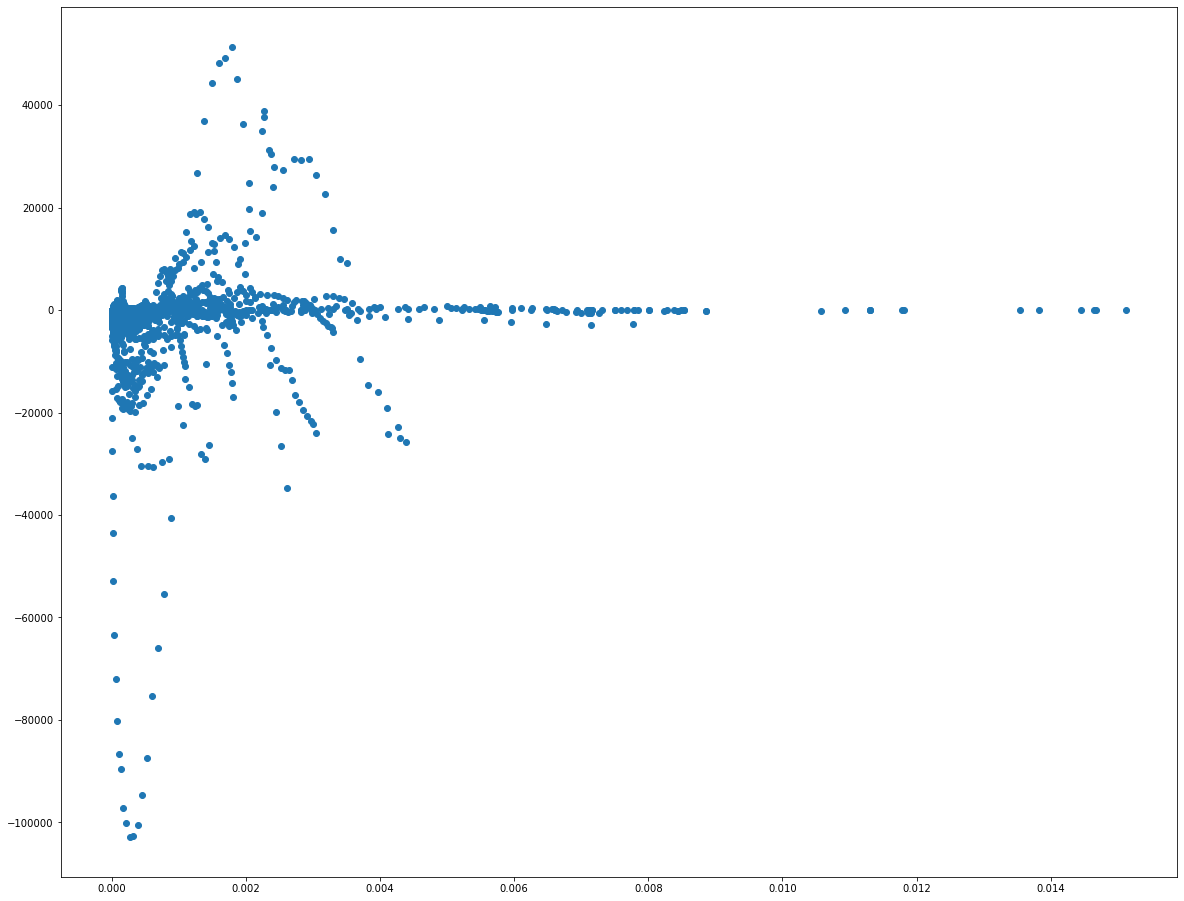

In [16]:
infection_per_million=[]
error=[]
error2=[]
for input in inputs:
    guess=good_linear_interpolation(input.input,input.population)
    #guess2=good_linear_interpolation2(input.input,input.population)
    real=input.output
    infection_per_million.append(input.input[-1]/input.population)
    error.append(guess-real)
    #error2.append(guess2-real)
plt.plot(infection_per_million,error, 'o',)
#plt.plot(infection_per_million,error2, 'o',)
plt.show()

Iz grafa ni razvidna neka korelacija. Poskusimo vseeno dodati nek faktor ki bo oblike 1/(a+b*odstotek_okuženih) ker morda pričakujemo da z naraščanjem števila okužb, narašča tudi količina ukrepov, ki jih država sprejema za zajezitev epidemije.

In [130]:
def generate_fit_from_weights_linear_afine_infection_percentage(w,w2):
    def linear_weight_interpolation_afine_infection(ls,population):
        weightedTerms=[w[i]*ls[-1-i] for i in range(len(w))]
        return sum(weightedTerms)/(w2[0]+w2[1]*(ls[-1]/population))
    
    return linear_weight_interpolation_afine_infection

def generate_good_linear_interpolation_with_afine_infection_percentage():
    weights=[0 for i in range(input_length)]#Recimo [0,0,0,0] da prvo funkcijo ki vedno vrne 0, [1,0,0,0] pa da funckijo ki gleda včeraj
    weights[0]=1+output_distance
    weights[1]=-output_distance
    weights2=[1,0]#((1+0*odstotek_okuženih)**-1)
    best=evaluate(generate_fit_from_weights_linear_afine_infection_percentage(weights,weights2))
    print(best)
    last=0
    w=0.5#velikost "povprečne" spremembe
    for i in range(25000): 
        if(i%400==0):
            print(i)
        if(random.random()<0.8):
            while(True):
                p=random.randrange(len(weights))
                if p in [0,1,2,4,7,10,13]:#Samo za toliko dni nazaj lahko gledamo. Preprečujemo overfit
                    break
            change=w*(random.random()-0.5)
            weights[p]+=change
            curr=evaluate(generate_fit_from_weights_linear_afine_infection_percentage(weights,weights2,))
            #print(str(weights)+" "+str(curr))
            if(curr<best):
                best=curr
                if i-last>150:
                    last=i
                    print(curr)
                    print(str(weights)+" "+str(weights2))
            else:
                weights[p]-=change
        else:
            w=5
            p=random.randrange(2)
            change=w*(random.random()-0.5)
            weights2[p]+=change
            #print(weights2)
            #print(str(weights)+" "+str(curr))
            curr=evaluate(generate_fit_from_weights_linear_afine_infection_percentage(weights,weights2,))
            if(curr<best):
                best=curr
                if i-last>150:
                    last=i
                    print(curr)
                    print(str(weights)+" "+str(weights2))
            else:
                weights2[p]-=change
            w=0.5
        
    print(best)
    print(weights)
    print(weights2)
    return generate_fit_from_weights_linear_afine_infection_percentage(weights,weights2)
    
good_linear_interpolation2=generate_good_linear_interpolation_with_afine_infection_percentage()

40.238257448
0
39.75398832334474
[8.000659699344514, -7.0, 0.005992616926088545, 0, 0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0] [1.0000000000000004, 4.83003810147829]
39.21197275617351
[8.000659699344514, -6.9986539983712674, 0.023600873283395274, 0, 0.0018464915150334105, 0, 0, 0.0, 0, 0, 0.0, 0, 0, -0.01502438778281917, 0, 0] [1.0000000000000004, 6.90587997710205]
400
38.53548813081585
[8.000659699344514, -6.99072468163175, 0.030242026136963918, 0, 0.0018464915150334105, 0, 0, 0.0, 0, 0, 0.002423046709088661, 0, 0, -0.01502438778281917, 0, 0] [1.0000000000000009, 13.625634748691265]
38.4214465100142
[8.000659699344514, -6.99072468163175, 0.030242026136963918, 0, 0.0018464915150334105, 0, 0, 0.008303688016470911, 0, 0, 0.002423046709088661, 0, 0, -0.01502438778281917, 0, 0] [1.0000000000000004, 16.178259051615072]
800
37.925731003185085
[8.014371967482564, -6.99072468163175, 0.03552958615340046, 0, 0.0018464915150334105, 0, 0, 0.008303688016470911, 0, 0, -0.010882310773796089, 0, 0, -

9600
36.581382102847144
[8.036380288870895, -6.976675047482359, 0.06376604039493072, 0, 0.003812668157701593, 0, 0, 0.010340153099824945, 0, 0, 0.0029112518219612804, 0, 0, 0.02114213910905738, 0, 0] [0.999999999999996, 50.890968568261115]
10000
36.57007183633397
[8.038928427223992, -6.976675047482359, 0.06376604039493072, 0, 0.0040252452409187955, 0, 0, 0.010340153099824945, 0, 0, 0.003917846361243371, 0, 0, 0.02114213910905738, 0, 0] [0.9999999999999956, 51.57343054619634]
36.532465904612295
[8.041654691288523, -6.976675047482358, 0.06376604039493072, 0, 0.0040252452409187955, 0, 0, 0.006953848012258235, 0, 0, 0.003917846361243371, 0, 0, 0.02114213910905738, 0, 0] [0.9999999999999961, 52.7597601885496]
10400
36.529747442049114
[8.041841600161938, -6.976675047482358, 0.06376604039493072, 0, 0.0040252452409187955, 0, 0, 0.006953848012258235, 0, 0, 0.003917846361243371, 0, 0, 0.02114213910905738, 0, 0] [0.9999999999999956, 52.544799456286206]
10800
36.524462717754254
[8.041841600161938,

22000
36.3917174178679
[8.05224859615663, -6.972295147606507, 0.06569652709116358, 0, -0.0034239639656457044, 0, 0, -0.002141341005880093, 0, 0, 0.0071110721242237385, 0, 0, 0.02656706480944704, 0, 0] [0.9999999999999964, 55.48056714468445]
22400
22800
36.39157643712665
[8.05224859615663, -6.972295147606507, 0.06623977721023727, 0, -0.0034239639656457044, 0, 0, -0.002141341005880093, 0, 0, 0.0071110721242237385, 0, 0, 0.02656706480944704, 0, 0] [0.9999999999999961, 55.48056714468444]
36.389618261930266
[8.05224859615663, -6.972295147606507, 0.06623977721023727, 0, -0.0034239639656457044, 0, 0, -0.0032902693775795355, 0, 0, 0.0071110721242237385, 0, 0, 0.02656706480944704, 0, 0] [0.9999999999999954, 55.685922173995365]
23200
36.37137856216709
[8.05224859615663, -6.972295147606507, 0.06623977721023727, 0, -0.0034239639656457044, 0, 0, -0.008243893931987545, 0, 0, 0.0071110721242237385, 0, 0, 0.028048912038761642, 0, 0] [0.999999999999996, 54.40955203494934]
36.365985414970105
[8.05224859

Izgleda kot da algoritmu pomaga da malo zniža oceno, če je precejšen odstotek prebivalstva že okužen, kar nekako sledi pričakovanjem. Dodamo še en fallback, če opazimo da je algoritem očitno naredil neumnost. 

In [18]:
def linear_with_fallback(ls,population):
    expected=good_linear_interpolation2(ls,population)
    if expected<=ls[-1]:#Če vrne da bo čez 7 dni manj primerov kot jih je danes, se to popravi 
        return ls[-1]
    else:
        return expected
    
evaluate(linear_with_fallback)

75.41870781146501

To izboljša rezultat za kakšnih 2-5%. No tudi to je nekaj. 

Preizkusimo še eno idejo: namesto da predvidevamo število okužb čez nekaj dni poskusimo izraziti spremembo števila okuženih od danes do konca z linearno kombinacijo sprememb do sedaj.

In [64]:
def generate_fit_from_diff_linear(w):
    def linear_diff_interpolation(ls,population):
        diff=[ls[-1-i]-ls[-2-i] for i in range(len(w))]
        weightedTerms=[w[i]*diff[i] for i in range(len(w))]
        return sum(weightedTerms)+ls[-1]
    
    return linear_diff_interpolation

def generate_good_diff_interpolation():
    weights=[0 for i in range(input_length-1)]#Recimo [0,0,0,0] da funkcijo ki vrne okužbe včeraj
    weights[0]=output_distance
    best=evaluate(generate_fit_from_diff_linear(weights))
    print(best)
    last=0
    w=0.5#velikost "povprečne" spremembe
    for i in range(25000): 
        if(i%400==0):
            print(i)
        while(True):
            p=random.randrange(len(weights))
            if p in [0,1,2,4,6,9,12]:#Samo za toliko dni nazaj lahko gledamo. Preprečujemo overfit
                break
        change=w*(random.random()-0.5)
        weights[p]+=change
        curr=evaluate(generate_fit_from_diff_linear(weights))
        #print(str(weights)+" "+str(curr))
        if(curr<best):
            best=curr
            if i-last>200:
                last=i
                print(curr)
                print(weights)
        else:
            weights[p]-=change
    print(best)
    print(weights)
    return generate_fit_from_diff_linear(weights)
    
good_diff_interpolation=generate_good_diff_interpolation()

40.238257448
0
33.53814944236618
[6.543823049908717, 0.8397777696227144, 1.101419277758704, 0, 0.046507085521787284, 0, -0.4691042590604826, 0, 0, -0.2554241692360548, 0, 0, -0.9534834680092317, 0, 0]
400
30.621007965487607
[5.409607760753976, 1.6943128668116918, 1.4256202724523357, 0, -0.1043893193771846, 0, -0.16204343733194804, 0, 0, -0.3006908015937165, 0, 0, -1.165143707107225, 0, 0]
29.664558385502986
[4.850605698498714, 2.0091631143559976, 1.7677043066405056, 0, -0.122462278436063, 0, -0.4286956862640422, 0, 0, -0.4936251356301374, 0, 0, -0.9004075129806821, 0, 0]
800
29.210775548395716
[4.6920189667689876, 2.2414345230554726, 1.849771316453932, 0, -0.015253651974552418, 0, -0.498795434658074, 0, 0, -0.8053704269042368, 0, 0, -0.7522177814929891, 0, 0]
29.111645843943677
[4.615518253822532, 2.3215779496716697, 1.8943135794172825, 0, -0.020765056379242475, 0, -0.4960883576496102, 0, 0, -0.8073652506900189, 0, 0, -0.7453243187363545, 0, 0]
1200
28.9956003338963
[4.478787158683929,

11200
28.607893890036472
[4.076251861979815, 2.9008373636937232, 2.2397446097504443, 0, -0.11983100123704876, 0, -0.7304086021483025, 0, 0, -1.4197606645544005, 0, 0, -0.13922876264994904, 0, 0]
11600
28.60782060925375
[4.076251861979815, 2.9008373636937232, 2.239744609750444, 0, -0.11983100123704876, 0, -0.732212645348643, 0, 0, -1.4197606645544005, 0, 0, -0.13168454275106883, 0, 0]
12000
28.606279476920005
[4.076251861979815, 2.9128862961322817, 2.239744609750444, 0, -0.11983100123704876, 0, -0.7347074463765565, 0, 0, -1.4394857365116795, 0, 0, -0.13168454275106883, 0, 0]
12400
28.606131242431648
[4.075421274700597, 2.9128862961322817, 2.243363736035808, 0, -0.11983100123704876, 0, -0.7347074463765564, 0, 0, -1.4394857365116795, 0, 0, -0.13168454275106883, 0, 0]
28.605379427614338
[4.070375112982646, 2.912206370469553, 2.243363736035808, 0, -0.11983100123704876, 0, -0.7347074463765564, 0, 0, -1.4394857365116795, 0, 0, -0.12027143144871533, 0, 0]
12800
28.604281875882272
[4.0619373953

Izgleda kot precej boljše kot pri linearni interpolaciji. Poskusimo sedaj z popravkom glede na število okužb

In [65]:
def generate_fit_from_diff_linear_with_afine(w,w2):
    def linear_diff_interpolation_afine(ls,population):
        diff=[ls[-1-i]-ls[-2-i] for i in range(len(w))]
        weightedTerms=[w[i]*diff[i] for i in range(len(w))]
        return (sum(weightedTerms)+ls[-1])/(w2[0]+w2[1]*(ls[-1]/population))
    
    return linear_diff_interpolation_afine

def generate_good_diff_interpolation_afine():
    weights=[0 for i in range(input_length-1)]#Recimo [0,0,0,0] da prvo funkcijo ki vedno vrne 0, [1,0,0,0] pa da funckijo ki gleda včeraj
    weights[0]=output_distance
    weights2=[1,0]#((1+2*odstotek_okuženih)**-1)
    best=evaluate(generate_fit_from_diff_linear_with_afine(weights,weights2))
    print(best)
    last=0
    w=0.5#velikost "povprečne" spremembe
    for i in range(25000): 
        if(i%400==0):
            print(i)
        if(random.random()<0.8):
            while(True):
                p=random.randrange(len(weights))
                if p in [0,1,2,4,8,10,12]:#Samo za toliko dni nazaj lahko gledamo. Preprečujemo overfit
                    break
            change=w*(random.random()-0.5)
            weights[p]+=change
            curr=evaluate(generate_fit_from_diff_linear_with_afine(weights,weights2,))
            #print(str(weights)+" "+str(curr))
            if(curr<best):
                best=curr
                if i-last>150:
                    last=i
                    print(curr)
                    print(str(weights)+" "+str(weights2))
            else:
                weights[p]-=change
        else:
            w=5
            p=random.randrange(2)
            change=w*(random.random()-0.5)
            weights2[p]+=change
            #print(weights2)
            #print(str(weights)+" "+str(curr))
            curr=evaluate(generate_fit_from_diff_linear_with_afine(weights,weights2,))
            if(curr<best):
                best=curr
                if i-last>150:
                    last=i
                    print(curr)
                    print(str(weights)+" "+str(weights2))
            else:
                weights2[p]-=change
            w=0.5
        
    print(best)
    print(weights)
    print(weights2)
    return generate_fit_from_diff_linear_with_afine(weights,weights2)
    
good_diff_interpolation_afine=generate_good_diff_interpolation_afine()

40.238257448
0
35.16963219414576
[6.965178698552121, 0.5649270137304676, 0.4587290433661491, 0, 0.050901549911322175, 0, 0, 0, -0.5194801334305181, 0, 0.07099009922106658, 0, -0.3427501917887214, 0, 0] [1.0, 6.495111975463112]
32.28964885295372
[6.234839603890694, 1.3416353264227192, 0.6332411814839254, 0, -0.03455767983168134, 0, 0, 0, -0.4861856909090541, 0, 0.1617067886225449, 0, -0.44074205498353086, 0, 0] [1.0, 10.87437097522514]
400
31.10199120873128
[5.949260186387292, 1.8010440431859642, 0.6332411814839254, 0, -0.03109829145612525, 0, 0, 0, -0.7924813241007138, 0, 0.4308953628457474, 0, -0.534508995493425, 0, 0] [1.0, 11.896748522637338]
30.296897511524246
[5.717709801475068, 2.0311572370947544, 0.800222695675886, 0, -0.10684330305681722, 0, 0, 0, -1.0246911333008635, 0, 0.5407181258854588, 0, -0.5078985368706433, 0, 0] [1.0, 11.284056035489357]
29.780985579929457
[5.4854996891732455, 2.071676684205947, 1.050646685260162, 0, -0.14800370458431827, 0, 0, 0, -1.0660835024164683, 0

28.39991386730645
[4.330838930099256, 2.8486291746697585, 1.7089262302778074, 0, -0.07030041254008279, 0, 0, 0, -1.8347569192182807, 0, 0.8107399043293437, 0, -0.4630255982992476, 0, 0] [1.000000000000003, 8.768594280383306]
7200
28.39534191619598
[4.305463600095358, 2.8486291746697585, 1.7089262302778074, 0, -0.035892950307854166, 0, 0, 0, -1.8499069491002336, 0, 0.8107399043293437, 0, -0.4637865446091047, 0, 0] [1.000000000000003, 8.953291964496351]
7600
28.39303996694078
[4.2949169861126215, 2.8486291746697585, 1.715208676780386, 0, -0.028033252170927392, 0, 0, 0, -1.8499069491002338, 0, 0.8078111725134942, 0, -0.4637865446091047, 0, 0] [1.000000000000003, 8.734309802029415]
28.391109523506778
[4.2902965858188225, 2.8553294461403667, 1.715208676780386, 0, -0.028033252170927392, 0, 0, 0, -1.8499069491002333, 0, 0.7958830833863744, 0, -0.4637865446091048, 0, 0] [1.0000000000000036, 8.734309802029415]
8000
28.38694726670603
[4.2902965858188225, 2.8553294461403667, 1.725208317242736, 0,

14800
28.35973811127689
[4.193646662923744, 2.927440465968889, 1.7602579569964392, 0, -0.006217189063365769, 0, 0, 0, -1.88597945258929, 0, 0.6653676887843827, 0, -0.32572999817070264, 0, 0] [1.0000000000000009, 8.75665816480905]
28.357975483038885
[4.193646662923744, 2.927440465968889, 1.7602579569964392, 0, -0.006217189063365769, 0, 0, 0, -1.8859794525892903, 0, 0.6482632218538205, 0, -0.30718938804780027, 0, 0] [1.0000000000000009, 8.75665816480905]
15200
28.357516533803064
[4.193646662923744, 2.927440465968889, 1.7701984317131232, 0, -0.006217189063365769, 0, 0, 0, -1.8859794525892906, 0, 0.6482632218538205, 0, -0.3071893880478002, 0, 0] [1.0000000000000004, 8.849475152857753]
28.35649236327983
[4.185012001748979, 2.927440465968889, 1.7815708192247688, 0, -0.006217189063365769, 0, 0, 0, -1.8859794525892903, 0, 0.6482632218538205, 0, -0.3071893880478002, 0, 0] [1.0000000000000004, 8.942679477893009]
15600
28.356428422470604
[4.185012001748978, 2.927440465968889, 1.7815708192247688, 

24000
28.34772675613922
[4.1604883171120655, 2.9525989078608745, 1.793977766568983, 0, -0.006622419670772595, 0, 0, 0, -1.8948963240499175, 0, 0.5859419062307445, 0, -0.24255426252367224, 0, 0] [0.9999999999999964, 9.096856796229595]
28.347607194182704
[4.1604883171120655, 2.9585925515358147, 1.793977766568983, 0, -0.006622419670772595, 0, 0, 0, -1.8948963240499173, 0, 0.5859419062307445, 0, -0.24255426252367224, 0, 0] [0.9999999999999964, 9.173332041545606]
24400
28.347607102716555
[4.1604883171120655, 2.9585925515358147, 1.7939777665689833, 0, -0.006622419670772595, 0, 0, 0, -1.8953853111704926, 0, 0.5859419062307445, 0, -0.24255426252367224, 0, 0] [0.9999999999999969, 9.173332041545606]
24800
28.347416166605303
[4.1604883171120655, 2.9598337500128915, 1.7939777665689838, 0, -0.006622419670772595, 0, 0, 0, -1.894190835116575, 0, 0.5792625958154074, 0, -0.24255426252367224, 0, 0] [0.9999999999999969, 9.173332041545606]
28.347416166605303
[4.1604883171120655, 2.9598337500128915, 1.7939

To nam da še boljši rezultat kot prej.Dodamo popravek za neumne odgovore in preverimo kako izgleda graf napak kjer primerjamo prejšnji in sedanji algoritem

In [136]:
def diff_with_fallback(ls,population):
    expected=good_diff_interpolation_afine(ls,population)
    if expected<=ls[-1]:#Če vrne da bo čez 7 dni manj primerov kot jih je danes, se to popravi 
        return ls[-1]
    else:
        return expected
    
evaluate(diff_with_fallback)

27.833033699220472

Všeč mi je da je izboljšava precej zanemarljiva. Torej je algoritem že sam po sebi precej v redu narejen da ne pomisli da bi bilo lahko v prihodnosti manj okužb kot jih je trenutno. 

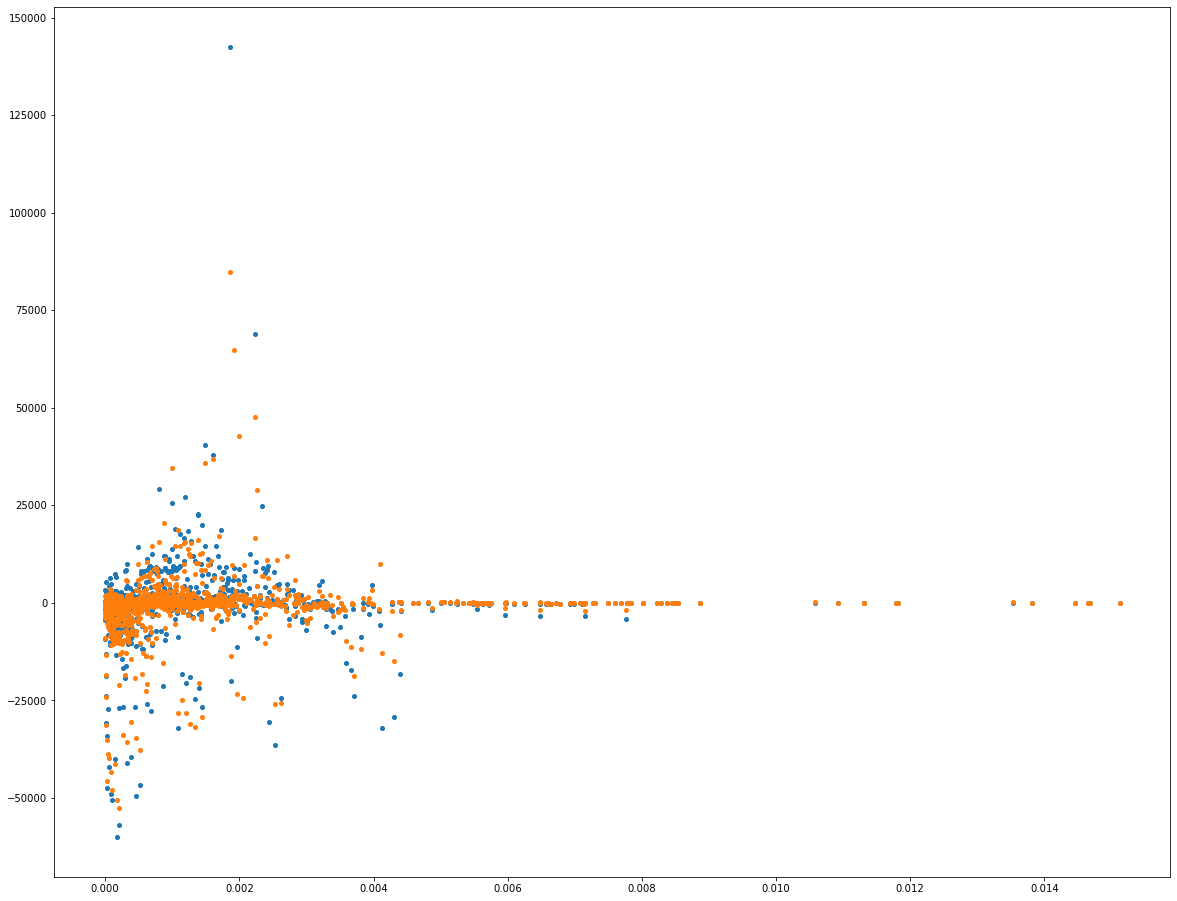

In [134]:
infection_per_million=[]
error=[]
error2=[]
for input in inputs:
    guess=linear_with_fallback(input.input,input.population)
    guess2=diff_with_fallback(input.input,input.population)
    real=input.output
    infection_per_million.append(input.input[-1]/input.population)
    error.append(guess-real)
    error2.append(guess2-real)
plt.plot(infection_per_million,error, 'o',markersize=4)
plt.plot(infection_per_million,error2, 'o',markersize=4)
plt.show()

Ta algoritem mi izgleda precej dober. Narišimo primerjavo med predictioni in resnico

In [133]:
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import *
import numpy.ma as ma
while(True):
    pos=random.randrange(len(series))
    row=series[pos]
    if(row[-sample_length-10]>50):
        print(pos)
        print(names[pos])
        break

print(row)
print(population[pos])
shift=0
def update(shift=10):

    x=np.arange(0, len(row), 1);
    y=[]
    lin_p=[]
    #exp_p=[]
    for i in range(len(row)):
        y.append(row[i])

    p=0
    while(p<len(row)):
        if p<sample_length or row[p-sample_length]<50:
            lin_p.append(0)
        else:
            lin_p.append(diff_with_fallback(y[p-sample_length:p-output_distance],population[pos]))
        p+=1

    #p=0
    #while(p<len(row)):
    #    if p<sample_length or row[p-sample_length]<50:
    #        exp_p.append(0)
    #    else:
    #        exp_p.append(log_weight_interpolation(y[p-sample_length:p-output_distance]))
    #    p+=1

    #errors_lin=[err(lin_p[i],y[i]) for i in range(len(row))]
    #errors_exp=[err(exp_p[i],y[i]) for i in range(len(row))]
    
    
    layerdict = dict()
    layerdict["Xc"] = x
    layerdict["Yc"] = y

    highlightmask = np.ones(len(layerdict['Xc'])).astype(bool)
    highlightmask[-output_distance-shift:] = False

    layerdict['Xc'] = ma.array(layerdict['Xc'])
    layerdict['Yc'] = ma.array(layerdict['Yc'], mask=highlightmask)

    plt.plot(layerdict['Xc'], layerdict['Yc'].data, label='linepath', linewidth=3.5)
    plt.plot(layerdict['Xc'], layerdict['Yc'], 'w', linewidth=3.5)
    
    layerdict2 = dict()
    layerdict2["Xc"] = x
    layerdict2["Yc"] = lin_p

    highlightmask2 = np.ones(len(layerdict2['Xc'])).astype(bool)
    highlightmask2[-shift:-shift+1] = False

    layerdict2['Xc'] = ma.array(layerdict2['Xc'])
    layerdict2['Yc'] = ma.array(layerdict2['Yc'], mask=highlightmask2)
    
    plt.plot(layerdict2['Xc'], layerdict2['Yc'].data, label='linepath', linewidth=.5)
    plt.plot(layerdict2['Xc'], layerdict2['Yc'], 'o', linewidth=3.5)
    plt.show()

interact(update, shift = widgets.IntSlider(value=10, min=0, max=80, step=1))

45
Estonia
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 10, 10, 10, 10, 12, 16, 16, 79, 115, 171, 205, 225, 258, 267, 283, 306, 326, 352, 369, 404, 538, 575, 645, 679, 715, 745, 779, 858, 961, 1039, 1097, 1108, 1149, 1185, 1207, 1258, 1304, 1309, 1332, 1373, 1400, 1434, 1459, 1512, 1528, 1535, 1552, 1559, 1592, 1605, 1635, 1643, 1647, 1660, 1666]
1291170


interactive(children=(IntSlider(value=10, description='shift', max=80), Output()), _dom_classes=('widget-inter…

<function __main__.update(shift=10)>

Izgleda kar v redu. To je najboljše kar sem uspel spraviti do sedaj. Naredimo malo oceno napak

In [139]:
averageMistake=0
for input in inputs:
    response=diff_with_fallback(input.input,input.population)
    correct=input.output
    averageMistake+=abs(correct-response)
    
averageMistake/=len(inputs)
print(averageMistake)

1565.5017304607716


In [169]:
#names,population
err_sum=[0 for i in range(len(names))]
count_sum=[0 for i in range(len(names))]
for input in inputs:
    response=diff_with_fallback(input.input,input.population)
    correct=input.output
    miss=abs(correct-response)
    err_sum[input.row]+=miss
    count_sum[input.row]+=1
print("Ime / Povprečje napak / število okužb v odstotkih / populacija / število okužb včeraj")
for c in range(len(names)):
    print(str(names[c])+" "+str((100*err_sum[c]/(1+count_sum[c]))/series[c][-1])+" "+str(population[c])+" "+str(series[c][-1]))

Ime / Povprečje napak / število okužb v odstotkih / populacija / število okužb včeraj
Afghanistan 5.916881795551483 29121286 1939
Albania 5.126666155133882 2986952 766
Algeria 4.837065121097194 34586184 3848
Andorra 3.7841510631322173 84000 743
Angola 0.0 13068161 27
Antigua and Barbuda 0.0 86754 24
Argentina 5.2430257660579285 41343201 4285
Armenia 5.635849777495806 2968000 1932
Austria 6.029758874215274 8205000 15402
Azerbaijan 5.792046504468152 8303512 1766
Bahamas 0.0 301790 80
Bahrain 9.427484506223628 738004 2921
Bangladesh 5.195733472974905 156118464 7103
Barbados 4.364598884204447 285653 80
Belarus 7.224184625182064 9685000 13181
Belgium 3.578973048006772 10403000 47859
Benin 0.0 9056010 64
Bhutan 0.0 699847 7
Bolivia 9.26178475515194 9947418 1110
Bosnia and Herzegovina 5.395212395510592 4590000 1677
Brazil 4.026092677888053 201103330 79685
Brunei 2.211833526273996 395027 138
Bulgaria 4.931364958918714 7148785 1447
Burkina Faso 6.793677691545106 16241811 641
Cabo Verde 0.0 5086